# Описание

Необходимо подключиться к базе с помощью SQLAlchemy и написать SQL-запросы в Jupyter Notebook для выполнения 10 заданий. 

Данные находятся в таблицах схемы `stackoverflow`:

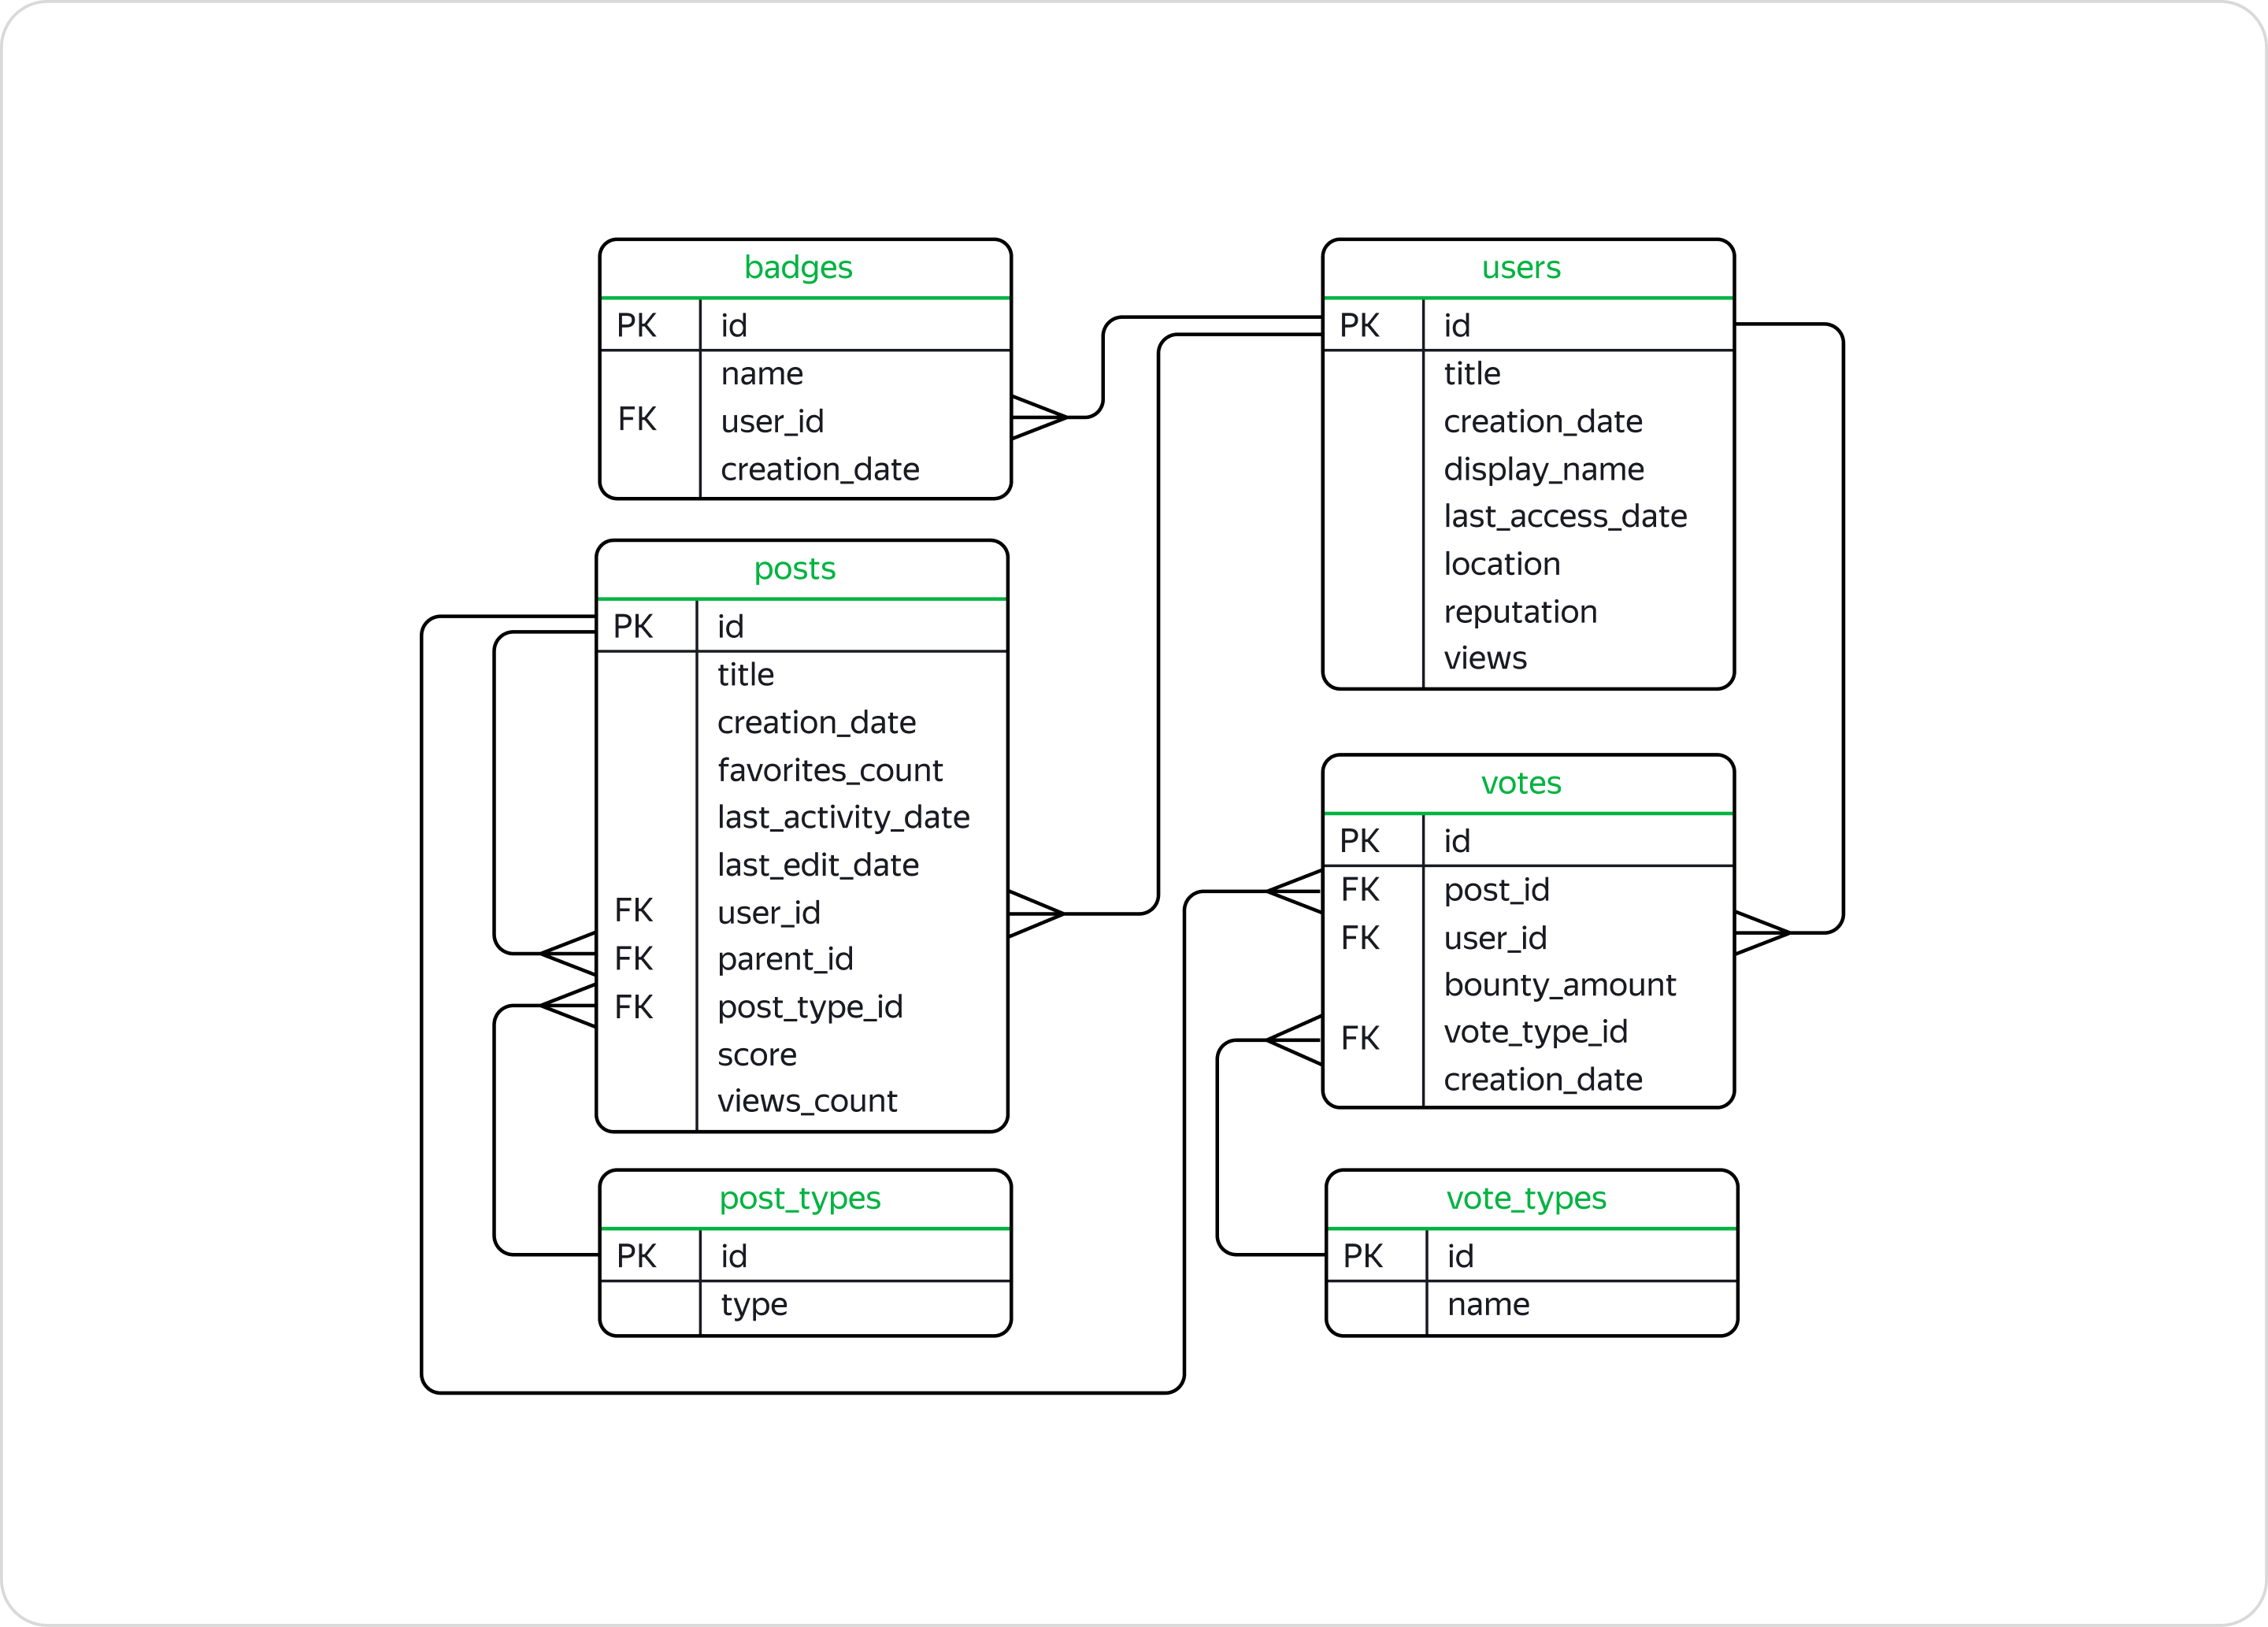

Некоторые задания включают дополнительные вопросы. 

Чтобы ожидаемый результат было легче представить, к каждому заданию добывлен небольшой фрагмент итоговой таблицы.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from sqlalchemy import create_engine 
from datetime import datetime 

# Подключение в БД

Конфигурация для подключения к базе данных `data-analyst-advanced-sql`  

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': '**********', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Тестовый запроса к базе данных

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT 
    DISTINCT DATE_TRUNC('month', creation_date) month_date,
    SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date)) views_in_month
FROM stackoverflow.posts
WHERE DATE_TRUNC('year', creation_date) = '01-01-2008'
ORDER BY 2 DESC;
'''

# выполните запрос
df1 = pd.read_sql_query(query, con=engine) 
df1

,month_date,views_in_month
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

**Ответ:**
Различие данных по месяцам обусловлено сезонностью. Так, наименьшее количество постов приходится на летние месяцы, а это сезон отпусков и каникул. Сентябрь и октябрь - месяцы с наибольшей активностью. 

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
WITH tm AS
    (SELECT 
        DISTINCT u.display_name,
        COUNT(*) OVER (PARTITION BY u.display_name)
    FROM stackoverflow.posts p
    LEFT JOIN stackoverflow.post_types t ON p.post_type_id=t.id
    LEFT JOIN stackoverflow.users u ON p.user_id=u.id
    WHERE p.creation_date - u.creation_date < interval '1 month'  
        AND t.type = 'Answer')
SELECT 
    DISTINCT t.display_name,
    COUNT(u.id) OVER (PARTITION BY t.display_name)
FROM tm t
LEFT JOIN stackoverflow.users u ON t.display_name=u.display_name
WHERE count > 100
ORDER BY 1; 
'''

# выполните запрос
df2 = pd.read_sql_query(query, con=engine) 
df2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,11
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


Какие аномалии наблюдаются в данных? О чём они говорят?

In [8]:
# посмотрим на повторы в именах
df22 = df2.loc[df2['count'] > 1]
print('Имён с повторами:', df22['count'].count())
df22.sort_values(by = 'count', ascending = False)

Имён с повторами: 19


,display_name,count
10,Chris,52
43,Matt,47
14,Dan,33
40,Mark,32
62,Tom,32
48,Nick,28
7,Brian,27
54,Rob,27
35,Kevin,23
57,Ryan,22


**Ответ:** Данные содержат 19 повторяющихся имён с разными id. Так 51 пользователь указал при регистрации имя Chris. Для таких пользователей, попадание в группу активных пользователей, которые в первый месяц после регистрации дали больше 100 ответов может иметь кумулятивный эффект. 

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
SELECT
    DISTINCT DATE_TRUNC('month', creation_date) cr_month,
    COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', creation_date))
FROM stackoverflow.posts
WHERE user_id IN (SELECT id
                 FROM stackoverflow.users
                 WHERE DATE_TRUNC('month', creation_date) = '01-09-2008')
  AND user_id IN (SELECT DISTINCT user_id
                 FROM stackoverflow.posts
                 WHERE DATE_TRUNC('month', creation_date) = '01-12-2008') 
ORDER BY 1 DESC;    
'''

# выполните запрос
df3 = pd.read_sql_query(query, con=engine) 
df3

,cr_month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

**Ответ:** Присутствуют данные за август, которых по условию быть не должно. То есть, у пользователей, зарегистрированных в сентябре есть посты за август Снижение активности в декабрю.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [10]:
# напишите запрос
query = '''
SELECT 
    user_id,
    creation_date,
    views_count, 
    SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS accum_views
FROM stackoverflow.posts
ORDER BY 1,
         2;
'''

# выполните запрос
df4 = pd.read_sql_query(query, con=engine) 
df4

,user_id,creation_date,views_count,accum_views
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [11]:
# напишите запрос
query = '''
SELECT user_id,
       COUNT(id)/COUNT(DISTINCT DATE_TRUNC('day', creation_date))::float daily
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date) = '01-08-2008'
GROUP BY 1
HAVING COUNT(id) > 120
ORDER BY 2;
'''

# выполните запрос
df5 = pd.read_sql_query(query, con=engine) 
df5

,user_id,daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [12]:
# напишите запрос
query = '''
SELECT AVG(days)::int result
FROM 
    (SELECT
        user_id,
        COUNT(DISTINCT creation_date::date) days
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '01-12-2008' AND '07-12-2008'
    GROUP BY 1) tmp;
'''

# выполните запрос
df6 = pd.read_sql_query(query, con=engine) 
df6

,result
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

**Ответ:** Сложно провести анализ по одному показателю в моменте, нет сопоставимых данных.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [13]:
# напишите запрос
query = '''
SELECT 
    user_id,
    creation_date, 
    to_char(LAG(creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date), 'Month') AS second_last_month
FROM stackoverflow.posts
ORDER BY 1,
         2;
'''

# выполните запрос
df7 = pd.read_sql_query(query, con=engine) 
df7

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [14]:
# напишите запрос
query = '''
WITH profiles AS
    (SELECT
        DISTINCT user_id,
        DATE_TRUNC('month', FIRST_VALUE(creation_date) OVER (PARTITION BY user_id ORDER BY creation_date)) cohort_dt
    FROM stackoverflow.posts),
    
cohort_users_cnt AS
    (SELECT *, 
        COUNT(*) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
    FROM profiles),
    
sessions AS
    (SELECT 
        user_id,
        DATE_TRUNC('month', creation_date) session_dt
    FROM stackoverflow.posts
    GROUP BY 1,
             2)
    
SELECT
    cohort_dt,
    session_dt,
    COUNT(cuc.user_id) AS users_cnt,
    cohort_users_cnt,
    ROUND(COUNT(cuc.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM cohort_users_cnt cuc
JOIN sessions s ON cuc.user_id = s.user_id
GROUP BY 1,
         2,
         4; 
'''

# выполните запрос
df8 = pd.read_sql_query(query, con=engine) 
df8

,cohort_dt,session_dt,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [15]:
# таблица карта Retention Rate
# из datetime начала когорты убираем время
df8['cohort_dt'] = pd.to_datetime(df8['cohort_dt']).dt.date
# добавляем lifetime
df8['lifetime'] = pd.DatetimeIndex(df8['session_dt']).month - pd.DatetimeIndex(df8['cohort_dt']).month
df81 = df8.pivot_table(
    index='cohort_dt',
    columns='lifetime',
    values='retention_rate'
)
df81

lifetime,0,1,2,3,4,5
cohort_dt,,,,,,
2008-07-01,100.0,66.67,33.33,66.67,33.33,66.67
2008-08-01,100.0,73.04,59.27,48.81,41.56,NaN
2008-09-01,100.0,53.82,38.63,32.56,NaN,NaN
2008-10-01,100.0,45.19,33.65,NaN,NaN,NaN
2008-11-01,100.0,40.36,NaN,NaN,NaN,NaN
2008-12-01,100.0,NaN,NaN,NaN,NaN,NaN


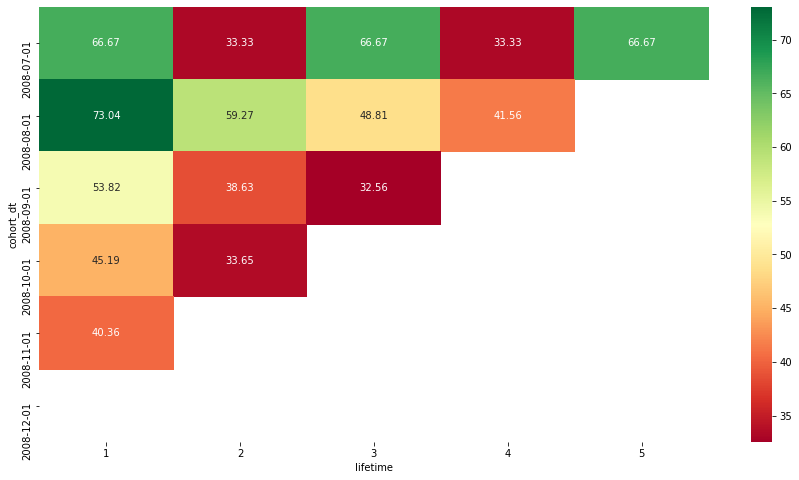

In [16]:
# тепловая карта Retention Rate
plt.figure(figsize=(15, 8))
sns.heatmap(
    df81.drop(columns=[0]), ## убираем нулевой день
    annot=True, 
    cmap='RdYlGn',
    fmt='.2f'
)
plt.show()

Опишите аномалии или другие необычные явления и сформулируйте гипотезы.

**Ответ:** Численность пользователей первой когорты мала (3 пользователя), данные по этой когорты необходимо исключать из анализа. Удержание по когортам (2-5) падает. Это опять же может быть обусловлено сезонностью. Так, для всех когорт характерно минимальное удержание в декабре. Можно полагать, что в январе показатель улучшаться. Тукущий горизон не позваляет делать одназначные выводы.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [17]:
# напишите запрос
query = '''
WITH tm AS
    (SELECT 
        DISTINCT EXTRACT(month FROM creation_date)::int creation_month,
        COUNT(*) OVER (PARTITION BY DATE_TRUNC('month',creation_date)) posts_count
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '01-09-2008' AND '31-12-2008') 
SELECT *,
    -- LAG(posts_count, 1) OVER (ORDER BY creation_month) AS previous_month_posts_cnt,
    ROUND((posts_count::numeric / LAG(posts_count, 1) OVER (ORDER BY creation_month) - 1)* 100 , 2) AS percentage
FROM tm;    
'''

# выполните запрос
df9 = pd.read_sql_query(query, con=engine) 
df9

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

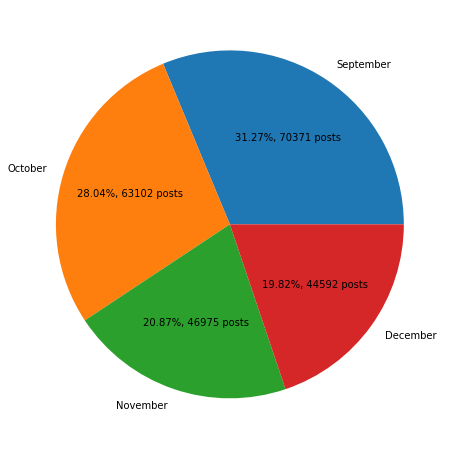

In [18]:
# постройте круговую диаграмму с количеством постов по месяцам 
plt.figure(figsize=(15, 8))
total_posts = df9['posts_count'].sum()
plt.pie(
    x = df9['posts_count'],
    labels = [(calendar.month_name[i]) for i in df9['creation_month']], 
    autopct = lambda p:f'{p:.2f}%, {p*total_posts/100 :.0f} posts'
)
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [19]:
# напишите запрос
query = '''
WITH our_user AS
    (SELECT 
        DISTINCT user_id uid,
        COUNT(id)
    FROM stackoverflow.posts
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 1)
SELECT 
    DISTINCT EXTRACT(week FROM creation_date)::int, 
    MAX(creation_date) OVER (PARTITION BY EXTRACT(week FROM creation_date))
FROM our_user u 
LEFT JOIN stackoverflow.posts p ON u.uid=p.user_id 
WHERE DATE_TRUNC('month', p.creation_date) = '01-10-2008';
'''

# выполните запрос
df10 = pd.read_sql_query(query, con=engine) 
df10

,date_part,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
